In [14]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [15]:
class SeabornFig2Grid():
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [16]:
def find_distances_to_sites(sim_data, sites):
    lattice = np.array(sim_data['sim_data']['lattice'][0][0])
    elements = [j.flat[0].flat[0] for j in sim_data['sim_data']['atom_element'][0][0]]
    frac_pos = np.array(sim_data['sim_data']['frac_pos'][0][0])
    frac_pos_sites = np.array(sites['sites']['frac_pos'][0][0])

    num_dimensions, num_atoms, num_time_steps = frac_pos.shape
    num_dimensions, num_centroids = frac_pos_sites.shape
    idx_Li = np.where(np.array(elements) == 'Li')[0]

    # Initialize clusters
    clusters_coords = [np.array([]).reshape((0, 3)) for _ in range(num_centroids)]
    # Assign each point to the cluster with the closest centroid
    for t in range(num_time_steps):
        differences = frac_pos[:, idx_Li, t, np.newaxis] - frac_pos_sites[:, np.newaxis, :]
        differences = np.where(differences > 0.5, differences - 1.0, differences)
        differences = np.where(differences < -0.5, differences + 1.0, differences)
        differences[0, :, :] *= lattice[0, 0]
        differences[1, :, :] *= lattice[1, 1]
        differences[2, :, :] *= lattice[2, 2]
        distances = np.sqrt(np.sum(differences.copy()**2, axis=0))
        min_indices = np.argmin(distances, axis=1)
        for j, min_cen in enumerate(min_indices):
            clusters_coords[min_cen] = np.append(clusters_coords[min_cen],differences[:,j,min_cen].reshape((1, 3)),axis=0)
    return clusters_coords

In [17]:
def transfer_16e(coords_Li):
    coords = np.array([]).reshape((0, 3))
    nr_sym = 4
    x = 1
    symmetry = np.array([(x,x,x), (-x,-x,x), (-x,x,-x), (x,-x,-x)])
    symmetry = np.repeat(symmetry, nr_sym, axis=0)
    symmetry = np.concatenate((symmetry, symmetry), axis=0)
    for idx in range(len(coords_Li)):
        coords_Li[idx] *= symmetry[idx,:]
        coords = np.append(coords,coords_Li[idx],axis=0)
    return coords

In [18]:
def transfer_48h(coords_Li):
    coords = np.array([]).reshape((0, 3))
    nr_sym = 4
    x = 1
    z = 1
    symmetry = np.array([(x,x,z),(-x,-x,z),(-x,x,-z),(x,-x,-z),(z,x,x),(z,-x,-x),(-z,-x,x),(-z,x,-x),(x,z,x),(-x,z,-x),(x,-z,-x),(-x,-z,x)])
    symmetry_code = np.array([1,1,1,1,2,2,2,2,3,3,3,3])
    symmetry = np.repeat(symmetry, nr_sym, axis=0)
    symmetry = np.concatenate((symmetry, symmetry), axis=0)
    symmetry_code = np.repeat(symmetry_code, nr_sym, axis=0)
    symmetry_code = np.concatenate((symmetry_code, symmetry_code), axis=0)
    for idx in range(len(coords_Li)):
        coords_Li[idx] *= symmetry[idx,:]
        if symmetry_code[idx] == 2:
            coords_Li[idx][:,0], coords_Li[idx][:,1], coords_Li[idx][:,2] = coords_Li[idx][:,2], coords_Li[idx][:,1], coords_Li[idx][:,0]
        elif symmetry_code[idx] == 3:
            coords_Li[idx][:,0], coords_Li[idx][:,1], coords_Li[idx][:,2] = coords_Li[idx][:,0], coords_Li[idx][:,2], coords_Li[idx][:,1]
        coords = np.append(coords,coords_Li[idx],axis=0)
    return coords

In [19]:
def plot_radius_shape(sim_data, sites):
    color_palette = sns.color_palette()
    sns.set_palette(color_palette)
    sns.set_style("ticks")

    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(3, 3)

    clusters_coords = find_distances_to_sites(sim_data, sites)
    sites_names = [j.flat[0].flat[0] for j in sites['sites']['full_names'][0][0]]
    site_clusters = [np.array([]).reshape((0, 3)) for _ in range(3)]

    sites_16e = np.where(np.array(sites_names) == '16e')[0]
    sites_48h = np.where(np.array(sites_names) == '48h')[0]
    sites_48h2 = np.where(np.array(sites_names) == '48h2')[0]

    site_clusters[0] = transfer_48h(np.array(clusters_coords)[sites_48h])
    site_clusters[1] = transfer_48h(np.array(clusters_coords)[sites_48h2])
    site_clusters[2] = transfer_16e(np.array(clusters_coords)[sites_16e])

    for i in range(3):
        distances = np.sqrt(np.sum(site_clusters[i].copy()**2, axis=1))
        print(['48h','48h2','16e'][i], ' MSD (A^2) = ',np.mean(distances.copy()**2),' std = ',np.std(distances.copy()**2))
        theta = np.linspace(0, 2 * np.pi, 100)  # 100 points around the circle
        x_circle = 0 + np.mean(distances) * np.cos(theta)
        y_circle = 0 + np.mean(distances) * np.sin(theta)

        g1 = sns.jointplot(x=site_clusters[i][:,0], y=site_clusters[i][:,1], marker='o', s=25, linewidth=2, color='black', alpha=0.7)
        sns.scatterplot(x=[0], y=[0], marker='D', s=40, linewidth=2, color=color_palette[0], ax=g1.ax_joint)
        sns.scatterplot(x=x_circle,y=y_circle, marker='o', s=10, linewidth=1, color=color_palette[0], ax=g1.ax_joint)
        g2 = sns.jointplot(x=site_clusters[i][:,0], y=site_clusters[i][:,2], marker='o', s=25, linewidth=2, color='black', alpha=0.7)
        sns.scatterplot(x=[0], y=[0], marker='D', s=40, linewidth=2, color=color_palette[0], ax=g2.ax_joint)
        sns.scatterplot(x=x_circle,y=y_circle, marker='o', s=10, linewidth=1, color=color_palette[0], ax=g2.ax_joint)
        g3 = sns.jointplot(x=site_clusters[i][:,1], y=site_clusters[i][:,2], marker='o', s=25, linewidth=2, color='black', alpha=0.7)
        sns.scatterplot(x=[0], y=[0], marker='D', s=40, linewidth=2, color=color_palette[0], ax=g3.ax_joint)
        sns.scatterplot(x=x_circle,y=y_circle, marker='o', s=10, linewidth=1, color=color_palette[0], ax=g3.ax_joint)

        mg0 = SeabornFig2Grid(g1, fig, gs[0,i])
        mg1 = SeabornFig2Grid(g2, fig, gs[1,i])
        mg2 = SeabornFig2Grid(g3, fig, gs[2,i])

        g1.ax_joint.set_xlabel('X')
        g1.ax_joint.set_ylabel('Y')
        g1.ax_joint.set_title(['48h','48h2','16e'][i])
        g2.ax_joint.set_xlabel('X')
        g2.ax_joint.set_ylabel('Z')
        g3.ax_joint.set_xlabel('Y')
        g3.ax_joint.set_ylabel('Z')

    gs.tight_layout(fig)
    plt.show()
    return fig

C:\Users\aklavrinenko\AppData\Local\Temp\ipykernel_16452\879247249.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  site_clusters[0] = transfer_48h(np.array(clusters_coords)[sites_48h])
C:\Users\aklavrinenko\AppData\Local\Temp\ipykernel_16452\879247249.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  site_clusters[1] = transfer_48h(np.array(clusters_coords)[sites_48h2])
C:\Users\aklavrinenko\AppData\Local\Temp\ipykernel_16452\879247249.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple

48h  MSD (A^2) =  0.3634667998757035  std =  0.3430634347078528
48h2  MSD (A^2) =  0.37102753105010566  std =  0.32786737867844007
16e  MSD (A^2) =  0.5033928915611013  std =  0.32638341594523823


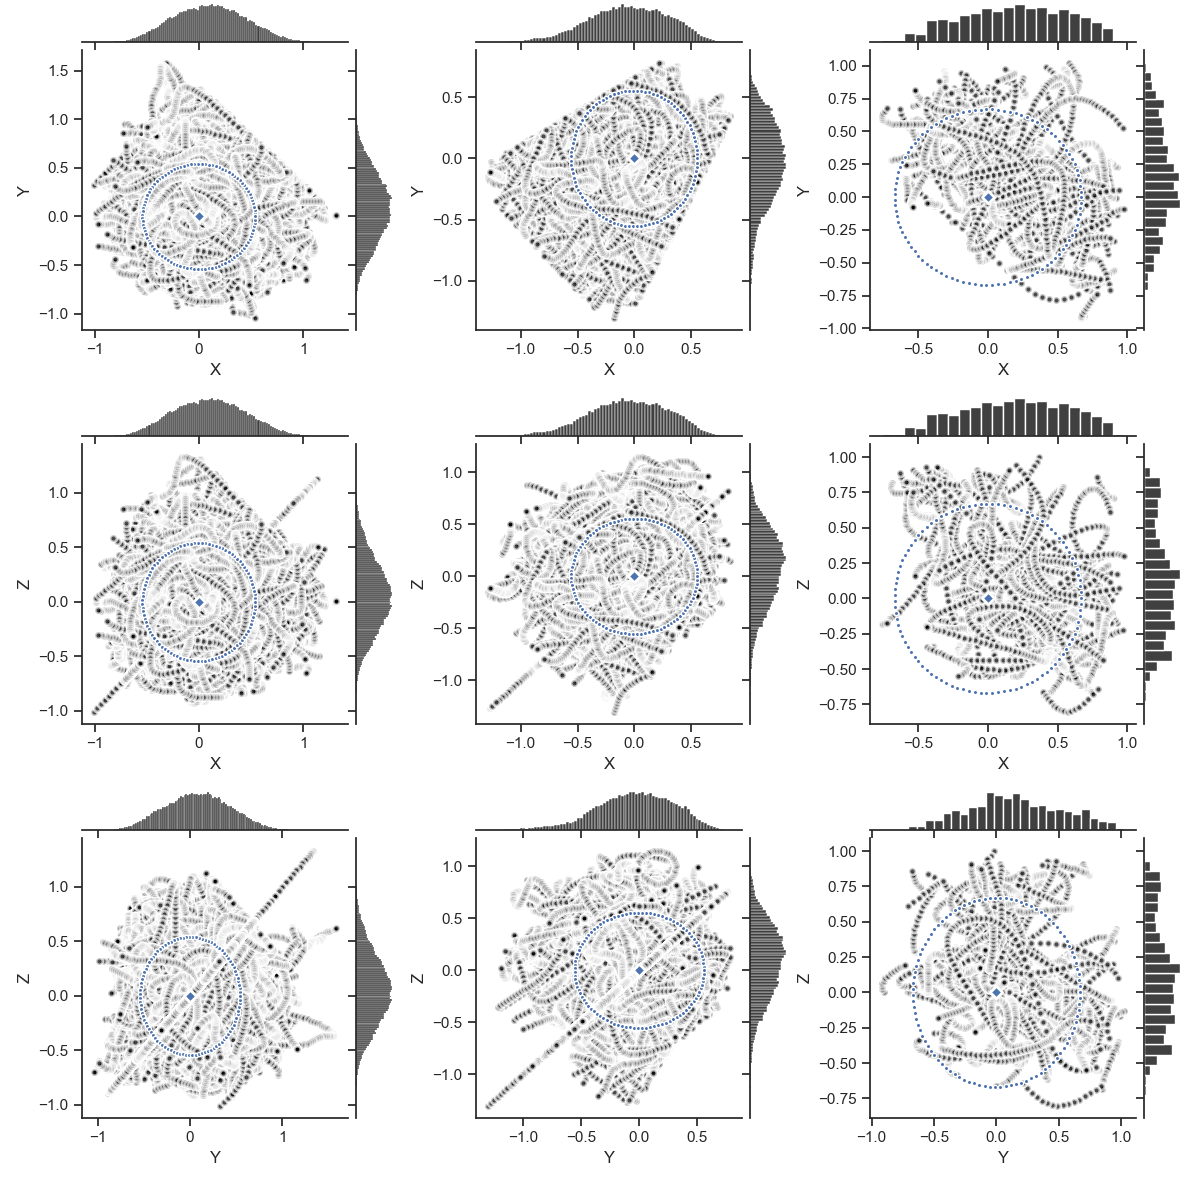

In [80]:
sim_data = sio.loadmat('md-analysis-matlab-example/shape_analysis/simulation_data.mat')
sites = sio.loadmat('md-analysis-matlab-example/shape_analysis/sites.mat')
fig = plot_radius_shape(sim_data, sites)